# Content Based Image Retrieval

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://drive.google.com/file/d/1ddx6eTR9ySTJbVwdxwSwtb_KpnG72R2w/view?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Download caltech256 dataset from kaggle

First go to the kaggle website and navigate to your account page and download the kaggle.json file then upload it to this colabs temp storage on the left.

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

In [1]:
#  first upload your kaggle json file

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download jessicali9530/caltech256
!unzip caltech256.zip

# !kaggle datasets download athota1/caltech101
# !unzip caltech101.zip
# !rm -rf /content/101_ObjectCategories/BACKGROUND_Google

Streaming output truncated to the last 5000 lines.
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0077.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0078.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0079.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0080.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0081.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0082.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0083.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0084.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0085.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0086.jpg  
  inflating: 256_objectcategories/256_ObjectCategories/228.triceratops/228_0087.jpg  
  i

## Installing `faiss`

In [2]:
!pip install faiss-gpu
!pip install mkl

     |████████████████████████████████| 85.5 MB 1.2 MB/s 


## Importing modules

In [50]:
import faiss

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import os
import time
import pickle
import numpy as np
from PIL import Image
from textwrap import wrap
from tqdm import tqdm, tqdm_notebook

## Create a database

Here we will make a slight modification to the ImageFolder class to retrieve the name of the file as well. Hence we will inherit the ImageFolder class.

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
  """Custom dataset that includes image file paths. Extends
  torchvision.datasets.ImageFolder
  Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
  """
  
  # override the __getitem__ method. this is the method that dataloader calls
  def __getitem__(self, index):
    # this is what ImageFolder normally returns 
    original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
    # the image file path
    path = self.imgs[index][0]
    # make a new tuple that includes original and the path
    tuple_with_path = (original_tuple + (path,))
    return tuple_with_path


Preprocessing the images

In [5]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('256_ObjectCategories', transforms_) # our custom dataset
# Random split your dataset into train and test
train_set_size = int(len(dataset) * 0.8)
test_set_size = len(dataset) - train_set_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])
print(f"[INFO] Length of train_set: {len(train_set)}")
print(f"[INFO] Length of test_set: {len(test_set)}")
print(f"[INFO] Total number of images: {len(test_set)+len(train_set)}")

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[INFO] Length of train_set: 24485
[INFO] Length of test_set: 6122
[INFO] Total number of images: 30607


In [6]:
train_dataloader = DataLoader(train_set)
test_dataloader  = DataLoader(test_set)

## Downloading a pretrained model

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)
# Show the model architecture
# model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

We will use the output of the last pooling layers to create the image descriptors

In [8]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

## Loading or Extracting features

In [9]:
# ~8 minutes for Caltech256 dataset on Colab Pro to iterate over data
extracting = True # [TODO]: Adjust to false if you are loading saved features

train_img_paths = []
test_img_paths = []
train_descriptors = []

model.to(DEVICE)
with torch.no_grad():
  model.eval()
  print("Extracting train set features and image paths.")
  for train_inputs, train_labels, train_paths in tqdm_notebook(train_dataloader):
    train_img_paths.append(train_paths)
    if extracting:  
      result = pooling_output(train_inputs.to(DEVICE))
      train_descriptors.append(result.cpu().view(1, -1).numpy())
    torch.cuda.empty_cache()
  print("Loading test set image paths")
  for test_inputs, test_labels, test_paths in tqdm_notebook(test_dataloader):
    test_img_paths.append(test_paths)

Extracting train set features and image paths.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/24485 [00:00<?, ?it/s]

Loading test set image paths


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/6122 [00:00<?, ?it/s]

# Save extracted features and image paths

Warning! variable saving and loading code has not been updated

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title
# save features and image paths if they were extracted for first time
if extracting:
  descriptors = np.vstack(descriptors)
  pickle.dump(descriptors, open('/content/drive/MyDrive/ImageSearchEngine/extracted_features/features-stacked-caltech256.pickle', 'wb'))
  pickle.dump(image_paths, open('/content/drive/MyDrive/ImageSearchEngine/extracted_features/image-paths-caltech256.pickle', 'wb'))

## Create a faiss index and search for images

In [ ]:
#@title
# Run cell if loading image paths and extracted features
if not extracting:
  saveFolder = '/content/drive/MyDrive/ImageSearchEngine/extracted_features/'
  with open(saveFolder + 'features-stacked-caltech256.pickle', 'rb') as f:
    descriptors = pickle.load(f)
  with open(saveFolder + 'image-paths-caltech256.pickle', 'rb') as f:
    image_paths = pickle.load(f)


In [11]:
print(f"[INFO] Number of train images: {len(train_img_paths)}")
print(f"[INFO] Number of test images: {len(test_img_paths)}")
print(f"[INFO] View train image paths: {train_img_paths[:5]}")
print(f"[INFO] View test image paths: {test_img_paths[:5]}")
print(f"[INFO] View trained feature vector: {train_descriptors[0]}")
print(f"[INFO] Trained feature vector shape: {train_descriptors[0].shape}")

[INFO] Number of train images: 24485
[INFO] Number of test images: 6122
[INFO] View train image paths: [('256_ObjectCategories/203.stirrups/203_0040.jpg',), ('256_ObjectCategories/217.tennis-court/217_0041.jpg',), ('256_ObjectCategories/224.touring-bike/224_0058.jpg',), ('256_ObjectCategories/044.comet/044_0096.jpg',), ('256_ObjectCategories/007.bat/007_0043.jpg',)]
[INFO] View test image paths: [('256_ObjectCategories/176.saddle/176_0002.jpg',), ('256_ObjectCategories/215.telephone-box/215_0082.jpg',), ('256_ObjectCategories/209.sword/209_0066.jpg',), ('256_ObjectCategories/145.motorbikes-101/145_0549.jpg',), ('256_ObjectCategories/088.golf-ball/088_0063.jpg',)]
[INFO] View trained feature vector: [[1.2293653  0.18572827 1.0845039  ... 0.6521614  0.8130137  0.28472263]]
[INFO] Trained feature vector shape: (1, 2048)


In [12]:
# Add trained features to FAISS index
index = faiss.IndexFlatL2(2048)
train_descriptors = np.vstack(train_descriptors)
index.add(train_descriptors)

In [13]:
# Helper function to get the classname from image path
def classname(str):
    return str.split('/')[-2]

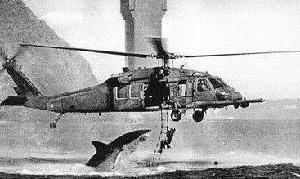

In [14]:
# [Warning!]: experimental code cell, edit before use
# query_image = '/content/drive/MyDrive/ImageSearchEngine/random_images/camera2.jpg'
query_image = '256_ObjectCategories/102.helicopter-101/102_0071.jpg'
# query_image = test_img_paths[1][0]
# print(query_image)
# print(classname(query_image))
PIL_img = Image.open(query_image)
PIL_img = PIL_img.convert('RGB')
PIL_img

Input Class: 102.helicopter-101
TruePositives: 6
FalsePositives: 3
Precision: 66.67


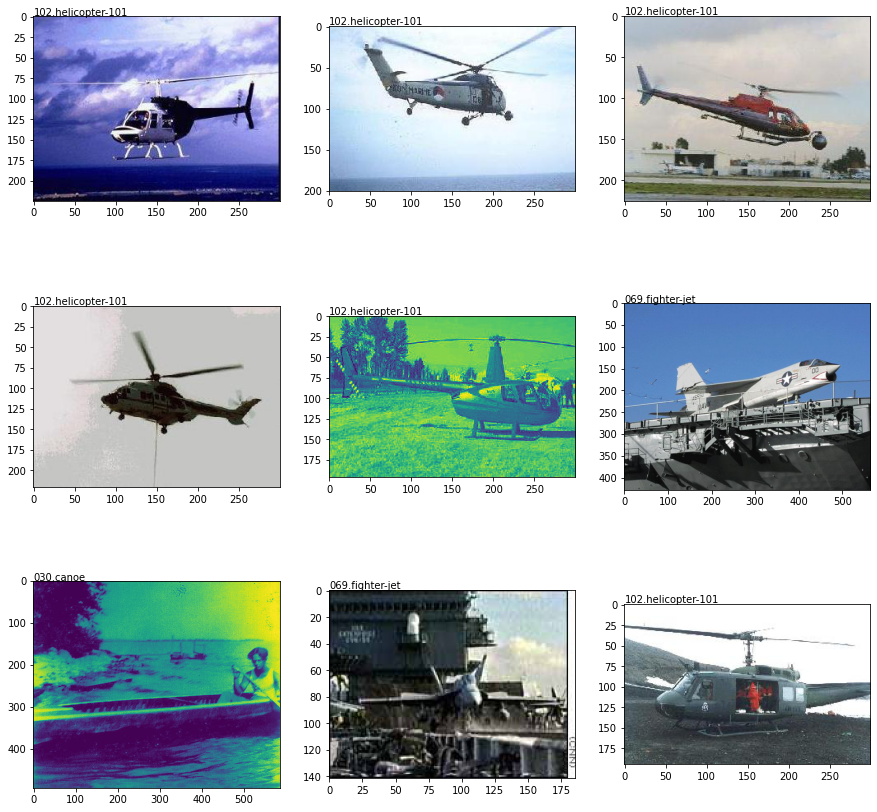

In [15]:
input_tensor = transforms_(PIL_img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
  query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
  distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)

truePositives = 0
falsePositives = 0

for file_index in indices[0]:
  sim_img_class = classname(train_img_paths[file_index][0])
  # print(sim_img_class)
  # if class is the same truePositives+=1 else falsePositives+=1 
  if sim_img_class == classname(query_image):
    truePositives = truePositives + 1
  else:
    falsePositives = falsePositives + 1
# outside of for loop calculate the recall and output it
precision = truePositives/(truePositives+falsePositives)
print("Input Class:",classname(query_image))
print("TruePositives:",truePositives)
print("FalsePositives:",falsePositives)
print("Precision:", round(precision*100,2))


fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
  ax_i.imshow(plt.imread(train_img_paths[file_index][0]))
  ax_i.text(0,-2,classname(train_img_paths[file_index][0]))

plt.show()

In [110]:
# for each input image path in test images
precisionsList = []

# parallelize this code
for num_neighbors in tqdm_notebook(range(2,11,2)):
  truePositives = 0
  falsePositives = 0
  for input_path in tqdm_notebook(test_img_paths):
    input_path = input_path[0]
    input_img_class = classname(input_path)
    # extract features of input image and find indices of similar images
    PIL_img = Image.open(input_path)
    PIL_img = PIL_img.convert('RGB')
    input_tensor = transforms_(PIL_img)
    input_tensor = input_tensor.view(1, *input_tensor.shape)
    with torch.no_grad():
      query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
      distance, indices = index.search(query_descriptors.reshape(1, 2048), num_neighbors)
    # for each similar image get the class name and compare to input class name
    for file_index in indices[0]:
      sim_img_class = classname(train_img_paths[file_index][0])
      if sim_img_class == input_img_class:
        truePositives = truePositives + 1
      else:
        falsePositives = falsePositives + 1

  precision_i = truePositives/(truePositives+falsePositives)
  precisionsList.append((num_neighbors, precision_i))
  print("truePositives:",truePositives)
  print("falsePositives:",falsePositives)
  print(f"Precision @ {num_neighbors}: {round(precision_i*100,2)}")

avgPrecision = sum(precisionsList)/len(precisionsList)
print("Average Precision:", round(avgPrecision*100,2))
# if this works well, think about how to incorporate distance value into performance calculation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/6122 [00:00<?, ?it/s]

truePositives: 9382
falsePositives: 2862
Precision @ 2: 76.63


  0%|          | 0/6122 [00:00<?, ?it/s]

truePositives: 18120
falsePositives: 6368
Precision @ 4: 74.0


  0%|          | 0/6122 [00:00<?, ?it/s]

truePositives: 26554
falsePositives: 10178
Precision @ 6: 72.29


  0%|          | 0/6122 [00:00<?, ?it/s]

truePositives: 34693
falsePositives: 14283
Precision @ 8: 70.84


  0%|          | 0/6122 [00:00<?, ?it/s]

truePositives: 42647
falsePositives: 18573
Precision @ 10: 69.66


ZeroDivisionError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


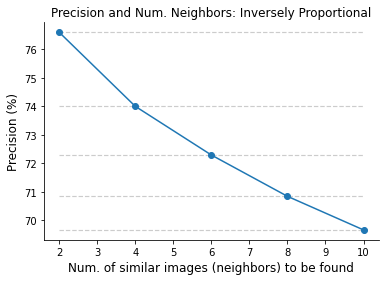

In [16]:
# data
def plotTrend(xdata, ydata, xlabel, ylabel, title):
  xdata = xdata
  ydata = ydata
  # plot the data
  fig = plt.figure()
  # hide the top and right spines
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  # Provide tick lines across the plot to help your viewers trace along    
  for y in ydata:    
    plt.plot(xdata, [y] * len(xdata), "--", lw=1.2, color="black", alpha=0.2)    

  ax = fig.add_subplot(1, 1, 1)
  ax.plot(xdata, ydata, color='tab:blue', marker="o")
  # create the events marking the x and y data points
  xevents1 = EventCollection(xdata, color='tab:blue', linelength=0.05)
  yevents1 = EventCollection(ydata, color='tab:blue', linelength=0.05,
                            orientation='vertical')
  # add the events to the axis
  ax.add_collection(xevents1)
  ax.add_collection(yevents1)
  ax.set_xlabel(xlabel, fontsize=12)
  ax.set_ylabel(ylabel, fontsize=12)
  ax.set_title(title)
  # display the plot
  plt.show()

xdata = range(2,11,2)
try:
  ydata = [i[1]*100 for i in precisionsList]
except:
  ydata = [76.6, 74.0, 72.29, 70.84, 69.66]
xlabel = 'Num. of similar images (neighbors) to be found'
ylabel = 'Precision (%)'
title = 'Precision and Num. Neighbors: Inversely Proportional'
plotTrend(xdata, ydata, xlabel, ylabel, title)


In [38]:
def get_least_accurate_classes(feature_list, filenames):
    per_class_acc = {}
    num_nearest_neighbors = 5
    num_correct_predictions = 0
    num_incorrect_predictions = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    for i in tqdm_notebook(range(len(feature_list))):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        ground_truth = classname(filenames[i][0])
        for j in indices[0]:
            predicted_class = classname(filenames[j][0])            
            if (predicted_class not in per_class_acc):
                per_class_acc[predicted_class] = [0, 0, 0]
            if ground_truth == predicted_class:
                num_correct_predictions += 1
                per_class_acc[predicted_class][0] += 1
                per_class_acc[predicted_class][2] += 1
            else:
                num_incorrect_predictions += 1
                per_class_acc[predicted_class][1] += 1
                per_class_acc[predicted_class][2] += 1
    print(
        "[INFO] Accuracy is",
        round(
            100.0 * num_correct_predictions /
            (1.0 * num_correct_predictions + num_incorrect_predictions), 2))
    for key, value in per_class_acc.items():
        per_class_acc[key] = round(100.0 * value[0] / (1.0 * value[2]), 2)
    dic = sorted(per_class_acc, key=per_class_acc.get)

    # least_accurate classes
    print("\n\n[INFO] Top 10 incorrect classifications\n")
    for key in dic[:10]:
        print(key, "\t\tAccuracy: ", per_class_acc[key])
    return dic[:6], per_class_acc

In [19]:
# Perform PCA over the features
# set the number of features intended
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(train_descriptors) 
pca_train_descriptors = pca.transform(train_descriptors)


Note: We are using the classes with the least accuracy because the effect of finetuning is expected be most pronounced on these categories. 

In [37]:
names_of_least_accurate_classes_before_finetuning, accuracy_per_class_before_finetuning = get_least_accurate_classes(
    pca_train_descriptors[:], train_img_paths)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/24485 [00:00<?, ?it/s]

Accuracy is  78.56


Top 10 incorrect classifications

173.rifle 	Accuracy:  44.19
163.playing-card 	Accuracy:  45.83
159.people 	Accuracy:  46.49
135.mailbox 	Accuracy:  46.6
195.soda-can 	Accuracy:  47.91
059.drinking-straw 	Accuracy:  50.47
233.tuning-fork 	Accuracy:  50.96
249.yo-yo 	Accuracy:  52.7
039.chopsticks 	Accuracy:  55.25
206.sushi 	Accuracy:  55.73


In [61]:
# Name was too long
worstClassesBeforeFinetuning = names_of_least_accurate_classes_before_finetuning

Combine the features from the 6 least accurate classes into a list so that we can use this list for further experiments and visualization. 

In [44]:
least_accurate_feature_list = []
least_accurate_filenames = []
least_accurate_count = {}

for index, filename in enumerate(train_img_paths):
  filename = filename[0]
  class_i = classname(filename) 
  if class_i not in least_accurate_count:
    least_accurate_count[class_i] = 0
  if class_i in worstClassesBeforeFinetuning and least_accurate_count[class_i] <= 50:
    least_accurate_feature_list.append(pca_train_descriptors[index])
    least_accurate_count[class_i] += 1
    least_accurate_filenames.append(class_i)

Train t-SNE only on the 6 least accurate classes.

In [48]:
selected_features = least_accurate_feature_list
selected_class_ids = least_accurate_filenames
selected_filenames = least_accurate_filenames
time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(selected_features)
# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250, metric=’euclidean’)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.000s...
[t-SNE] Computed neighbors for 306 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 6.012893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.296638
[t-SNE] KL divergence after 1000 iterations: 0.895307
t-SNE done! Time elapsed: 1.8465325832366943 seconds


### t-SNE visualization of feature vectors of least accurate classes before finetuning

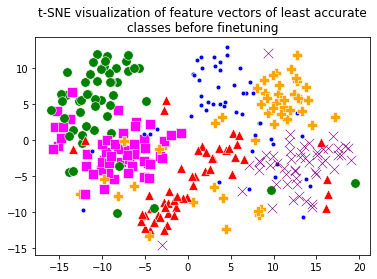

In [51]:
plt.title("\n".join(wrap(
        "t-SNE visualization of feature vectors of least accurate classes before finetuning",
        60)))
set_classes = list(set(selected_class_ids))
# set different markers for all the classes we are going to show
markers = ["^", ".", "s", "o", "x", "P"]
# set different colors for all the classes we are going to show
colors = ['red', 'blue', 'fuchsia', 'green', 'purple', 'orange']
class_to_marker = {}
class_to_color = {}
for index in range(len(tsne_results)):
    # assign color and marker to each type of class
    if selected_class_ids[index] not in class_to_marker:
        class_to_marker[selected_class_ids[index]] = markers.pop()
    if selected_class_ids[index] not in class_to_color:
        class_to_color[selected_class_ids[index]] = colors.pop()
    plt.scatter(tsne_results[index, 0],
                tsne_results[index, 1],
                c=class_to_color[selected_class_ids[index]],
                marker=class_to_marker[selected_class_ids[index]],
                edgecolor='white',
                linewidth='.6',
                s=90)

plt.show()